# Eye for Blind – Image Captioning with Attention

# 1. Objective

Eye for Blind: An Assistive Image Captioning System with Visual Attention

This project implements a deep learning model that generates natural language descriptions of images, particularly aimed at visually impaired users. The model leverages an attention mechanism to selectively focus on image regions when generating each word, mimicking human vision.

Inspired by "Show, Attend and Tell" (Xu et al., 2015), this implementation:
1. Uses a CNN encoder (InceptionV3) to extract image features.
2. Applies additive (Bahdanau) attention during decoding.
3. Employs a decoder LSTM to generate captions.
4. Converts generated captions to speech using gTTS.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# 0 (default): All messages (INFO, WARNING, ERROR) are logged.
# 1: INFO messages are not printed.
# 2: INFO and WARNING messages are not printed.
# 3: INFO, WARNING, and ERROR messages are not printed.

import re
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image
from typing import Dict, List, Tuple, Optional
import tensorflow as tf #type: ignore
from tensorflow.keras import layers, Model #type: ignore
from tensorflow.keras.optimizers.schedules import CosineDecay #type: ignore
from tensorflow.keras.losses import SparseCategoricalCrossentropy #type: ignore
from tensorflow.keras.preprocessing.text import Tokenizer #type: ignore
from tensorflow.keras.preprocessing.sequence import pad_sequences #type: ignore
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction #type: ignore
from gtts import gTTS #type: ignore
from IPython.display import Audio, display
import tqdm

In [2]:
CONFIG = {
    'subset_ratio' : 1.0,
    'image_dir': '/home/flickr30k_images/flickr30k_images',
    'caption_file': '/home/flickr30k_images/flickr30k_images/results.csv',
    
    # GPU Utilization
    'batch_size': 64,            # Fully utilize 48GB VRAM; reduce if OOM
    'buffer_size': 10000,        # Larger shuffle buffer helps training stability
    
    # Model Capacity
    'max_length': 30,            # Reasonable for captions
    'embedding_dim': 512,        # Good for attention + LSTM
    'units': 512,                # LSTM/Attention size
    
    # Training Behavior
    'seed': 42,
    'epochs': 20,                # Slightly more for small dataset
    'patience': 8,               # Early stopping tolerance
    'learning_rate': 3e-4,       # Lower for small datasets to reduce overfitting
    'grad_clip_value': 5.0,      # Prevent exploding gradients
    
    # Vocabulary
    'vocab_min_count': 3,        # Include more words for small run
    
    # Output & Precision
    'checkpoint_dir': './checkpoints/10pct',
    'mixed_precision': False,     # RTX 6000 Ada has 4th-gen Tensor Cores—use them
}

In [3]:
# Set random seeds for reproducibility
tf.random.set_seed(CONFIG['seed'])
np.random.seed(CONFIG['seed'])
random.seed(CONFIG['seed'])

# Mixed precision policy - RTX 6000 Ada has excellent mixed precision support
if CONFIG['mixed_precision']:
    policy = tf.keras.mixed_precision.Policy('mixed_float16')
    tf.keras.mixed_precision.set_global_policy(policy)
    print("Mixed precision enabled for RTX 6000 Ada")

# Single GPU setup
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    # Enable memory growth for RTX 6000 Ada
    for gpu in physical_devices:
        tf.config.experimental.set_memory_growth(gpu, True)
    
    # Use default strategy for single GPU
    strategy = tf.distribute.get_strategy()
    print(f"Using single GPU: {physical_devices[0].name}, batch size={CONFIG['batch_size']}")
else:
    print("No GPUs found, using CPU")
    strategy = tf.distribute.get_strategy()

# Constants
AUTOTUNE = tf.data.AUTOTUNE

Using single GPU: /physical_device:GPU:0, batch size=64


In [4]:
class DataProcessor:
    def __init__(self, config):
        self.config = config
        self.captions_dict = dict()
        self.tokenizer = None
        self.vocab_size = 0
        self.train_data = []
        self.val_data = []
        self.test_data = []
    
    def load_captions(self) -> Dict[str, List[str]]:
        """Load and convert pipe-delimited Flickr-style caption file to a dict."""
        print(f"Loading captions from {self.config['caption_file']}")
        df = pd.read_csv(self.config['caption_file'], sep='|', header=None, 
                         names=['image_name', 'comment_number', 'comment'], engine='python')
        df['image_name'] = df['image_name'].str.strip()
        df['comment'] = df['comment'].str.strip()
        
        caption_map = {}
        for img, group in df.groupby('image_name'):
            caption_map[img] = group['comment'].tolist()
        
        self.captions_dict = caption_map
        print(f"Loaded {len(caption_map)} images with captions")
        return caption_map
    
    def display_samples(self, num_samples: int = 3):
        """Display random images with all their associated captions."""
        if not self.captions_dict:
            self.load_captions()

        sample_keys = random.sample(list(self.captions_dict.keys()), min(num_samples, len(self.captions_dict)))

        for key in sample_keys:
            img_path = os.path.join(self.config['image_dir'], key)
            try:
                img = Image.open(img_path)
                plt.figure(figsize=(8, 6))
                plt.imshow(img)
                plt.axis('off')
                plt.title(key)
                plt.show()

                for cap in self.captions_dict[key]:
                    print(f"- {cap}")
                print()
            except Exception as e:
                print(f"Error loading image {key}: {e}")

    def preprocess_caption(self, caption: str) -> Optional[str]:
        """Clean and format caption text."""
        if caption is None or not isinstance(caption, str):
            return None
        caption = caption.lower()
        caption = re.sub(r"[^a-z0-9.,? ]", "", caption)
        return f"<start> {caption.strip()} <end>"

    def prepare_captions(self, subset_ratio=1.0):
        """Process captions, build tokenizer & train/val/test splits."""
        if not self.captions_dict:
            self.load_captions()

        # --- 1. clean & tag ----------------------------------------------------
        all_captions = []
        for caps in self.captions_dict.values():
            for c in caps:
                p = self.preprocess_caption(c)
                if p:
                    all_captions.append(p)

        word_counts = Counter(w for cap in all_captions for w in cap.split())
        valid_words = {w for w, cnt in word_counts.items()
                    if cnt >= self.config['vocab_min_count']}

        def keep(c):
            return all(w in valid_words or w in ('<start>', '<end>') for w in c.split())

        filtered = [c for c in all_captions if keep(c)]

        # --- 2. determine max length ------------------------------------------
        lengths = [len(c.split()) for c in filtered]
        self.config['max_length'] = int(np.percentile(lengths, 95))
        print(f"max_length set to {self.config['max_length']}")

        # --- 3. build tokenizer (NO filters so < and > stay) -------------------
        tokenizer = Tokenizer(oov_token="<unk>", filters='', lower=True)
        tokenizer.fit_on_texts(filtered)
        self.tokenizer = tokenizer
        self.vocab_size = len(tokenizer.word_index) + 1
        print(f"vocab size = {self.vocab_size}")

        # --- 4. build (image, caption) list ------------------------------------
        pairs = []
        for img, caps in self.captions_dict.items():
            for c in caps:
                p = self.preprocess_caption(c)
                if p and keep(p):
                    pairs.append((img, p))

        if subset_ratio < 1.0:
            pairs = pairs[:int(len(pairs) * subset_ratio)]
            print(f"subset: {len(pairs)} pairs")

        random.shuffle(pairs)
        n = len(pairs)
        self.train_data, self.val_data, self.test_data = (
            pairs[:int(0.8*n)],
            pairs[int(0.8*n):int(0.9*n)],
            pairs[int(0.9*n):],
        )
        print(f"split  →  train {len(self.train_data)} | val {len(self.val_data)} | test {len(self.test_data)}")

        return filtered
        
    def encode_caption(self, caption: str) -> Tuple[np.ndarray, int]:
        """Convert caption text to sequence of token ids."""
        if self.tokenizer is None:
            raise ValueError("Tokenizer not initialized. Call prepare_captions first.")
        
        seq = self.tokenizer.texts_to_sequences([caption])[0]
        padded_seq = pad_sequences([seq], maxlen=self.config['max_length'], padding='post')[0]
        return padded_seq, len(seq)

    @tf.function(input_signature=[tf.TensorSpec([], tf.string)])
    def _base_decode(self, path: tf.Tensor) -> tf.Tensor:
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)          # [0,1]
        return img                                                   # (h,w,3)

    @tf.function(input_signature=[tf.TensorSpec([], tf.string)])
    def load_image_train(self, path: tf.Tensor) -> tf.Tensor:
        """Augment + preprocess (training only)."""
        img = self._base_decode(path)
        img = tf.image.random_flip_left_right(img)                   # aug ①

        # resize shorter side→342 then *random* crop 299×299
        shape = tf.shape(img)[:2]
        scale = 342. / tf.cast(tf.reduce_min(shape), tf.float32)
        new_hw = tf.cast(tf.cast(shape, tf.float32) * scale, tf.int32)
        img = tf.image.resize(img, new_hw)
        img = tf.image.random_crop(img, size=[299, 299, 3])          # aug ②

        img = tf.keras.applications.inception_v3.preprocess_input(img)
        return tf.ensure_shape(img, [299, 299, 3])

    @tf.function(input_signature=[tf.TensorSpec([], tf.string)])
    def load_image_eval(self, path: tf.Tensor) -> tf.Tensor:
        """Deterministic centre-crop (validation / inference)."""
        img = self._base_decode(path)

        # resize shorter side→342 then *central* crop 299×299
        shape = tf.shape(img)[:2]
        scale = 342. / tf.cast(tf.reduce_min(shape), tf.float32)
        new_hw = tf.cast(tf.cast(shape, tf.float32) * scale, tf.int32)
        img = tf.image.resize(img, new_hw)
        img = tf.image.resize_with_crop_or_pad(img, 299, 299)

        img = tf.keras.applications.inception_v3.preprocess_input(img)
        return tf.ensure_shape(img, [299, 299, 3])

    def data_generator(self, data):
        """Generator for *training* / *val* datasets."""
        for img, cap in data:
            img_path = os.path.join(self.config['image_dir'], img)
            img_tensor = self.load_image_train(tf.convert_to_tensor(img_path))
            token_ids, cap_len = self.encode_caption(cap)
            yield img_tensor, token_ids, cap_len
    
    def build_dataset(self, data, shuffle=True, cache=True, training: bool=True):
        """Create a tf.data.Dataset optimized for single GPU."""
        output_signature = (
            tf.TensorSpec((299, 299, 3), tf.float32),
            tf.TensorSpec((self.config['max_length'],), tf.int32),
            tf.TensorSpec((), tf.int32)
        )

        ds = tf.data.Dataset.from_generator(
            lambda: self.data_generator(data),
            output_signature=output_signature
        )

        if cache:
            ds = ds.cache()
        if shuffle:
            ds = ds.shuffle(self.config['buffer_size'])

        ds = ds.batch(self.config['batch_size'])
        ds = ds.prefetch(AUTOTUNE)
        return ds

    def prepare_datasets(self):
        """Prepare all datasets for training/validation/testing."""
        if not self.train_data:
            self.prepare_captions()

        print("Building datasets...")
        train_ds = self.build_dataset(self.train_data)
        val_ds = self.build_dataset(self.val_data)
        test_ds = self.build_dataset(self.test_data, shuffle=False)
        
        return train_ds, val_ds, test_ds

In [5]:
class Encoder(Model):
    """
    MobileNet-V3 Small feature extractor.
    Outputs flattened map  (B, 49, 576)  from 224×224 inputs.
    """
    def __init__(self):
        super().__init__(name="encoder")
        base = tf.keras.applications.MobileNetV3Small(
            include_top=False,
            include_preprocessing=True,
            weights="imagenet",
            input_shape=(224, 224, 3),
        )
        base.trainable = False                          # phase-1: frozen
        self.cnn = Model(inputs=base.input, outputs=base.output)
        self.flatten = layers.Reshape((-1, base.output_shape[-1]))  # 7×7 → 49

    def unfreeze_top_layers(self, n: int = 2):
        for layer in self.cnn.layers[-n:]:
            layer.trainable = True

    def call(self, x):                                   # (B,299,299,3) → resize
        x = tf.image.resize(x, (224, 224))
        x = self.cnn(x)                                  # (B,7,7,576)
        return self.flatten(x)                           # (B,49,576)

In [6]:
class SeqEmbedding(layers.Layer):
    def __init__(self, vocab_size, max_length, depth):
        super().__init__()
        self.token_emb = layers.Embedding(vocab_size, depth, mask_zero=True)
        self.pos_emb   = layers.Embedding(max_length, depth)
        self.add       = layers.Add()

    def call(self, seq):                                 # (B,T) → (B,T,D)
        tok = self.token_emb(seq)
        pos = self.pos_emb(tf.range(tf.shape(seq)[1])[tf.newaxis])
        return self.add([tok, pos])

class CausalSelfAttention(layers.Layer):
    def __init__(self, units, num_heads=2, dropout=0.1):
        super().__init__()
        self.mha       = layers.MultiHeadAttention(num_heads, units, dropout=dropout)
        self.add       = layers.Add()
        self.norm      = layers.LayerNormalization()

    def call(self, x):
        attn = self.mha(query=x, value=x, use_causal_mask=True)
        return self.norm(self.add([x, attn]))            # (B,T,D)

class CrossAttention(tf.keras.layers.Layer):
    def __init__(self, units, num_heads=2, dropout=0.1):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=units,
            dropout=dropout)

        self.add  = tf.keras.layers.Add()
        self.norm = tf.keras.layers.LayerNormalization()

        # will hold (batch, heads, target_len, source_len) each forward pass
        self.last_attention_scores = None

    def call(self, tgt, src):                          # tgt=text, src=image
        attn, scores = self.mha(
            query=tgt, value=src,
            return_attention_scores=True)

        self.last_attention_scores = scores            # stash for later plots
        return self.norm(self.add([tgt, attn]))

class FeedForward(layers.Layer):
    def __init__(self, units, dropout=0.1):
        super().__init__()
        self.seq  = tf.keras.Sequential([
            layers.Dense(units*2, activation="relu"),
            layers.Dense(units),
            layers.Dropout(dropout),
        ])
        self.norm = layers.LayerNormalization()

    def call(self, x):
        return self.norm(x + self.seq(x))                # (B,T,D)

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, units, num_heads=2, dropout=0.1):
        super().__init__()
        self.self_attn  = CausalSelfAttention(units, num_heads, dropout)
        self.cross_attn = CrossAttention(units, num_heads, dropout)
        self.ff         = FeedForward(units, dropout)

        # expose attention map for this layer
        self.last_attention_scores = None

    def call(self, tgt, src):
        x = self.self_attn(tgt)                # causal self-attention
        x = self.cross_attn(x, src)            # cross-attention to image
        self.last_attention_scores = self.cross_attn.last_attention_scores
        return self.ff(x)                      # feed-forward + residual/Norm

# ─────────────────────────── 3.  Decoder ────────────────────────────────
class TransformerDecoder(Model):
    """
    2-layer Transformer decoder with cross-attention over image features.
    """
    def __init__(self,
                 vocab_size:  int,
                 max_length:  int,
                 units:       int = 256,
                 num_layers:  int = 2,
                 num_heads:   int = 2,
                 dropout:     float = 0.1):
        super().__init__(name="decoder")

        self.embed = SeqEmbedding(vocab_size, max_length, units)

        # Use a different attribute name – NOT `layers`
        self.dec_layers = [
            DecoderLayer(units, num_heads, dropout) for _ in range(num_layers)
        ]

        self.out = layers.Dense(vocab_size)

    def call(self, tokens, features):              # tokens (B,T)  features (B,L,C)
        x = self.embed(tokens)                     # (B,T,D)
        for dec_layer in self.dec_layers:
            x = dec_layer(x, features)             # (B,T,D)
        return self.out(x)                         # (B,T,V)

In [7]:
class ImageCaptioningModel:
    def __init__(self, config, processor):
        self.config          = config
        self.processor       = processor
        self.encoder         = None
        self.decoder         = None
        self.optimizer       = None
        self.loss_fn         = None
        self.ckpt_manager    = None

        self.best_bleu       = 0.0
        self.train_loss_log  = []
        self.train_bleu_log  = []
        self.val_bleu_log    = []
        self.bleu_subset_idx = None  

        self.smoothie = SmoothingFunction().method4
    
    def build_model(self):
        """
        Build the MobileNet-V3 + 2-layer Transformer-decoder captioning model.
        (Single-GPU; no distribution strategy.)
        """
        print("Building Transformer-based image-captioning model …")

        # ── 1.  Encoder ──────────────────────────────────────────────────────
        self.encoder = Encoder()       # new MobileNet-V3 feature extractor

        # ── 2.  Decoder ──────────────────────────────────────────────────────
        self.decoder = TransformerDecoder(
            vocab_size  = self.processor.vocab_size,
            max_length  = self.config['max_length'],
            units       = self.config['embedding_dim'],  # 256-512 works fine
            num_layers  = 2,
            num_heads   = 2,
            dropout     = 0.1,
        )

        # ── 3.  Optimizer & loss ─────────────────────────────────────────────
        lr_schedule       = CosineDecay(
            initial_learning_rate = self.config['learning_rate'],
            decay_steps           = 10_000,
        )
        self.optimizer    = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
        self.loss_fn      = tf.keras.losses.SparseCategoricalCrossentropy(
                                from_logits=True, reduction='none')

        # ── 4.  Checkpointing ────────────────────────────────────────────────
        ckpt_dir          = self.config['checkpoint_dir']
        os.makedirs(ckpt_dir, exist_ok=True)

        ckpt              = tf.train.Checkpoint(
                                encoder   = self.encoder,
                                decoder   = self.decoder,
                                optimizer = self.optimizer)
        self.ckpt_manager = tf.train.CheckpointManager(ckpt, ckpt_dir, max_to_keep=3)

        if self.ckpt_manager.latest_checkpoint:
            ckpt.restore(self.ckpt_manager.latest_checkpoint)
            print(f"Restored from checkpoint: {self.ckpt_manager.latest_checkpoint}")

    def summary(self):
        """
        Print layer summaries for the MobileNet-V3 encoder and the
        Transformer decoder stack.
        """
        # ---------- Encoder --------------------------------------------------
        print("\nEncoder (MobileNet-V3) Summary:")
        dummy_img = tf.zeros((1, 299, 299, 3))   # input is auto-resized to 224²
        _ = self.encoder(dummy_img)              # build weights
        self.encoder.summary()

        # ---------- Transformer Decoder --------------------------------------
        print("\nTransformer Decoder Summary:")
        dummy_feat   = tf.zeros((1, 49, 576))    # flattened 7×7 map from encoder
        dummy_tokens = tf.zeros((1, self.config['max_length'] - 1), tf.int32)
        _ = self.decoder(dummy_tokens, dummy_feat)  # build weights
        self.decoder.summary()

    @tf.function
    def train_step(self, img_tensor, target, cap_len):
        """
        One-call sequence training (no step-loop, no scheduled sampling).
        """
        tokens_inp   = target[:, :-1]              #  ⟨start⟩ … ⟨n-1⟩
        tokens_label = target[:, 1:]               #  … ⟨end⟩

        with tf.GradientTape() as tape:
            features = self.encoder(img_tensor)    # (B,49,576)
            logits   = self.decoder(tokens_inp, features)  # (B,T-1,V)

            ce = self.loss_fn(tokens_label, logits)        # (B,T-1)
            mask = tf.cast(tokens_label > 0, ce.dtype)
            loss = tf.reduce_sum(ce * mask) / tf.reduce_sum(mask)

        vars_  = self.encoder.trainable_variables + self.decoder.trainable_variables
        grads  = tape.gradient(loss, vars_)
        grads, _ = tf.clip_by_global_norm(grads, self.config['grad_clip_value'])
        self.optimizer.apply_gradients(zip(grads, vars_))
        return loss

    def evaluate_bleu(self, test_data, max_samples=None):
        """Calculate BLEU scores on test data."""
        refs, hyps = [], []
        data_to_eval = test_data[:max_samples] if max_samples else test_data
        
        for img_name, _ in tqdm.tqdm(data_to_eval):
            image_path = os.path.join(self.config['image_dir'], img_name)
            hyp = self.greedy_decode(image_path)
            
            # Process ground truth captions
            gt = [self.processor.preprocess_caption(c).split() for c in self.processor.captions_dict[img_name][:5]]
            gt = [[w for w in cap if w not in ('<start>', '<end>')] for cap in gt]
            
            refs.append(gt)
            hyps.append(hyp)
        
        # Calculate BLEU scores for different n-grams
        bleu_scores = {}
        for i in range(1, 5):
            weights = tuple([1.0/i]*i + [0.0]*(4-i))
            score = corpus_bleu(refs, hyps, weights=weights, smoothing_function=self.smoothie)
            bleu_scores[f'bleu-{i}'] = score
            print(f"BLEU-{i}: {score:.4f}")
        
        return bleu_scores

    def train(self,
            train_ds,
            val_data,                    # → same list-of-pairs you already pass in
            subset_size: int = 200):     # kept for quick-BLEU hooks (optional)
        """
        Transformer training loop (no scheduled sampling, no step-loop).

        • Tracks X-entropy on training *and* validation splits.
        • Early-stops on best **val-loss**.
        • BLEU hooks are disabled by default; you can re-enable once
        you’ve rebuilt `greedy_decode`/`evaluate_bleu` for the new model.
        """
        epochs = self.config['epochs']

        if epochs is None:
            epochs = self.config['epochs']

        # build deterministic (no-shuffle) val tf.data.Dataset once
        val_ds = self.processor.build_dataset(val_data, shuffle=False, training=False)

        patience = self.config['patience']
        wait     = 0
        best_val = np.inf

        for epoch in range(epochs):
            start = time.time()
            total_loss, steps = 0.0, 0

            progbar = tf.keras.utils.Progbar(None, stateful_metrics=['loss'])

            for batch, (img_tensor, target, cap_len) in enumerate(train_ds):
                if batch == 0 and progbar.target is None:
                    progbar.target = (
                        len(self.processor.train_data) //
                        self.config['batch_size'] + 1
                    )

                batch_loss = self.train_step(img_tensor, target, cap_len)
                total_loss += batch_loss
                steps += 1
                progbar.update(batch + 1, values=[('loss', batch_loss)])

            train_loss = total_loss / steps
            self.train_loss_log.append(float(train_loss))

            # ---------- validation loss ----------
            val_total, val_steps = 0.0, 0
            for img_tensor, target, _ in val_ds:
                features     = self.encoder(img_tensor)
                tokens_inp   = target[:, :-1]
                tokens_label = target[:, 1:]

                logits = self.decoder(tokens_inp, features)
                ce     = self.loss_fn(tokens_label, logits)

                mask   = tf.cast(tokens_label > 0, ce.dtype)
                loss   = tf.reduce_sum(ce * mask) / tf.reduce_sum(mask)

                val_total += loss
                val_steps += 1

            val_loss = val_total / val_steps
            self.val_bleu_log.append(float(val_loss))  # repurposed as val-loss log

            # ---------- checkpoint & early-stop ----------
            self.ckpt_manager.save()
            if val_loss < best_val:
                best_val = val_loss
                wait = 0
            else:
                wait += 1
                if wait >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

            print(f"Epoch {epoch+1}: "
                f"train-loss={train_loss:.4f}  val-loss={val_loss:.4f}  "
                f"time={time.time()-start:.1f}s",
                flush=True)

        return self.train_loss_log, self.val_bleu_log
    
    def plot_history(self):
        """Plot loss curve **and** both train/val BLEU-4 curves."""
        plt.figure(figsize=(14, 5))

        # --- left: training loss ---
        plt.subplot(1, 2, 1)
        plt.plot(self.train_loss_log, label='Train Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Cross-Entropy Loss')
        plt.title('Training Loss')
        plt.grid(True)
        plt.legend()

        # --- right: BLEU-4 ---
        plt.subplot(1, 2, 2)
        if self.train_bleu_log:
            plt.plot(self.train_bleu_log, label='Train BLEU-4')
        plt.plot(self.val_bleu_log,   label='Val BLEU-4')
        plt.xlabel('Epoch')
        plt.ylabel('BLEU-4')
        plt.title('BLEU-4 Scores')
        plt.grid(True)
        plt.legend()

        plt.tight_layout()
        plt.show()
    
    def speak_caption(self, caption: str, filename="caption_audio.mp3"):
        """Generate speech audio from caption text."""
        if not caption:
            print("Empty caption, nothing to speak")
            return
            
        tts = gTTS(text=caption, lang='en')
        tts.save(filename)
        display(Audio(filename))
        print(f"Audio saved to {filename}")
    
    def prime_dataset(self, ds, steps: int = None) -> None:
        """
        Pre-fill a tf.data shuffle buffer so the first training epoch
        starts without the usual “Filling up shuffle buffer …” pause.

        Args
        ----
        ds    : the *un-iterated* tf.data.Dataset you’ll pass to train()
        steps : number of iterator steps to advance; default uses
                buffer_size // batch_size + 1 from config.
        """
        if steps is None:
            steps = self.config['buffer_size'] // self.config['batch_size'] + 1

        it = iter(ds)
        for _ in range(steps):
            try:
                next(it)
            except StopIteration:  # dataset shorter than requested priming
                break

    def fine_tune_cnn(self,
                      train_ds,
                      val_data,
                      layers_to_unfreeze: int = 2,
                      lr: float = 1e-5,
                      epochs: int = 1):
        """
        Phase-2 fine-tuning of the top Inception blocks.
        Call after initial caption training for an extra accuracy bump.
        """
        print(f"\nUnfreezing top {layers_to_unfreeze} Inception blocks …")
        self.encoder.unfreeze_top_layers(layers_to_unfreeze)

        # New, low learning-rate optimiser
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

        print(f"Fine-tuning CNN for {epochs} epoch(s) at lr={lr} …")
        self.train(train_ds, val_data, epochs=epochs)

        print("CNN fine-tune finished.")

    # ──────────────────── Transformer greedy_decode ────────────────────────
    def greedy_decode(self, image_path: str):
        """
        Greedy caption generation for the Transformer decoder.
        Returns a list of predicted words (no <start>/<end>/<unk>).
        """
        # 1. deterministic crop → feature map
        img_tensor = tf.expand_dims(
            self.processor.load_image_eval(tf.convert_to_tensor(image_path)), 0
        )                                                      # (1,299,299,3)
        features = self.encoder(img_tensor)                   # (1,49,576)

        # 2. token loop
        start_id = self.processor.tokenizer.word_index['<start>']
        end_id   = self.processor.tokenizer.word_index['<end>']

        tokens = [start_id]
        for _ in range(self.config['max_length'] - 1):
            inp = tf.expand_dims(tokens, 0)                   # (1,t)
            logits = self.decoder(inp, features)              # (1,t,vocab)
            next_id = int(tf.argmax(logits[0, -1, :]))        # last step

            if next_id == end_id:
                break
            tokens.append(next_id)

        words = [self.processor.tokenizer.index_word.get(i, '')
                for i in tokens[1:]                         # skip <start>
                if self.processor.tokenizer.index_word.get(i, '')
                not in ('<start>', '<end>', '<unk>')]

        return words

    # ───────────────────── updated evaluate_bleu ────────────────────────────
    def evaluate_bleu(self, test_data, max_samples: int):
        """
        Compute BLEU-1 … BLEU-4 on the given (image, caption) pairs
        using the Transformer-based greedy decoder.
        """
        refs, hyps = [], []
        data_to_eval = test_data[:max_samples] if max_samples else test_data

        for img_name, _ in tqdm.tqdm(data_to_eval):
            image_path = os.path.join(self.config['image_dir'], img_name)

            # ── hypothesis ─────────────────────────────────────────
            hyp = self.greedy_decode(image_path)
            hyps.append(hyp)

            # ── references (5 ground-truth captions per image) ─────
            gt_caps = [self.processor.preprocess_caption(c).split()
                    for c in self.processor.captions_dict[img_name][:5]]
            gt_caps = [[w for w in cap if w not in ('<start>', '<end>')]
                    for cap in gt_caps]
            refs.append(gt_caps)

        # ── BLEU-n scores ─────────────────────────────────────────
        bleu_scores = {}
        for n in range(1, 5):
            weights = tuple([1.0 / n] * n + [0.0] * (4 - n))
            score = corpus_bleu(refs, hyps,
                                weights=weights,
                                smoothing_function=self.smoothie)
            bleu_scores[f'bleu-{n}'] = score
            print(f"BLEU-{n}: {score:.4f}")

        return bleu_scores

    def demo(self,
            image_path: str,
            filename: str = "caption_audio.mp3",
            temperature: float = 0.0):
        """
        End-to-end demo for the Transformer model:
        1. Show image
        2. Print ground-truth captions
        3. Generate caption (greedy)
        4. Text-to-speech playback
        5. Attention heat-maps
        """
        if not os.path.exists(image_path):
            print(f"Image not found: {image_path}")
            return

        # ---------- 1. show original image ----------
        img = Image.open(image_path)
        plt.figure(figsize=(8, 6))
        plt.imshow(img); plt.axis('off'); plt.show()

        # ---------- 2. ground-truth captions ----------
        img_name = os.path.basename(image_path)
        gt_caps  = self.processor.captions_dict.get(img_name, [])
        if gt_caps:
            print("Ground-truth captions:")
            for cap in gt_caps:
                print(f"- {cap}")
        else:
            print("No ground-truth captions found.")

        # ---------- 3. caption generation ----------
        words = self.greedy_decode(image_path)
        caption = " ".join(words)
        print("\nGenerated caption:")
        print(caption)

        # ---------- 4. audio ----------
        self.speak_caption(caption, filename=filename)

        # ---------- 5. attention heat-maps ----------
        # 5-a  Run once more to collect attention scores
        img_tensor = tf.expand_dims(
            self.processor.load_image_eval(tf.convert_to_tensor(image_path)), 0)
        features   = self.encoder(img_tensor)

        start_id = self.processor.tokenizer.word_index['<start>']
        token_ids = [self.processor.tokenizer.word_index.get(w,
                    self.processor.tokenizer.word_index['<unk>']) for w in words]
        tokens_inp = tf.expand_dims([start_id] + token_ids, 0)  # (1,T)

        _ = self.decoder(tokens_inp, features)  # populates .last_attention_scores

        # 5-b  Stack and average attention maps: (layers, heads) → mean
        att_stack = tf.stack([layer.last_attention_scores
                            for layer in self.decoder.dec_layers], axis=0)
        # (L,b,h,T,S)  →  (T,S)
        att_mean = tf.reduce_mean(att_stack, axis=[0,1,2])[0].numpy()

        # # 5-c  Split into per-token list for existing plot_attention()
        # alphas = [att_mean[t] for t in range(att_mean.shape[0])]
        # self.plot_attention(image_path, words, alphas)


In [8]:
processor = DataProcessor(CONFIG)

In [9]:
_ = processor.load_captions()

Loading captions from /home/flickr30k_images/flickr30k_images/results.csv
Loaded 31784 images with captions


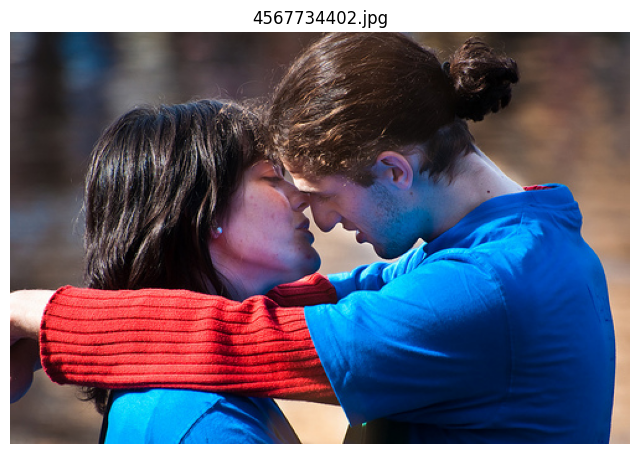

- A man in a blue and red shirt hugs a woman in a blue top .
- A man and a woman are about to kiss .
- A woman and a man getting closer .
- A couple that is about to kiss .
- Two young people are kissing .



In [10]:
processor.display_samples(1)

In [11]:
processor.prepare_captions(subset_ratio=CONFIG['subset_ratio'])[:20]

max_length set to 25
vocab size = 10009
split  →  train 118132 | val 14767 | test 14767


['<start> two young guys with shaggy hair look at their hands while hanging out in the yard . <end>',
 '<start> two young , white males are outside near many bushes . <end>',
 '<start> two men in green shirts are standing in a yard . <end>',
 '<start> a man in a blue shirt standing in a garden . <end>',
 '<start> several men in hard hats are operating a giant pulley system . <end>',
 '<start> workers look down from up above on a piece of equipment . <end>',
 '<start> two men working on a machine wearing hard hats . <end>',
 '<start> four men on top of a tall structure . <end>',
 '<start> three men on a large rig . <end>',
 '<start> a child in a pink dress is climbing up a set of stairs in an entry way . <end>',
 '<start> a little girl in a pink dress going into a wooden cabin . <end>',
 '<start> a little girl climbing the stairs to her playhouse . <end>',
 '<start> a little girl climbing into a wooden playhouse <end>',
 '<start> a girl going into a wooden building . <end>',
 '<start> s

In [12]:
train_ds, val_ds, _ = processor.prepare_datasets()

Building datasets...


In [13]:
model = ImageCaptioningModel(CONFIG, processor)
model.build_model()

Building Transformer-based image-captioning model …


In [14]:
model.summary()


Encoder (MobileNet-V3) Summary:
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 7, 7, 576)         939120    
                                                                 
 reshape (Reshape)           multiple                  0         
                                                                 
Total params: 939,120
Trainable params: 0
Non-trainable params: 939,120
_________________________________________________________________

Transformer Decoder Summary:
Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 seq_embedding (SeqEmbedding  multiple                 5137408   
 )                                                               
                                                                 
 decoder_layer (DecoderLayer  multiple 

In [15]:
model.prime_dataset(train_ds, steps=20)

In [16]:
reduced_val = random.sample(processor.val_data, 100)

In [17]:
# model.train(train_ds, processor.val_data)
model.train(train_ds, reduced_val)

1846/1846 [==============================] - 898s 451ms/step - loss: 2.9198
Epoch 1: train-loss=3.4542  val-loss=3.1519  time=903.3s
1846/1846 [==============================] - 61s 33ms/step - loss: 3.0379
Epoch 2: train-loss=2.9334  val-loss=2.9868  time=61.6s
1846/1846 [==============================] - 59s 32ms/step - loss: 2.7948
Epoch 3: train-loss=2.7152  val-loss=2.9241  time=60.3s
1846/1846 [==============================] - 62s 34ms/step - loss: 2.5037
Epoch 4: train-loss=2.5397  val-loss=2.9132  time=62.9s
1846/1846 [==============================] - 61s 33ms/step - loss: 2.5452
Epoch 5: train-loss=2.4186  val-loss=2.9066  time=61.4s
1846/1846 [==============================] - 62s 34ms/step - loss: 2.4855
Epoch 6: train-loss=2.3714  val-loss=2.9060  time=63.1s
1846/1846 [==============================] - 62s 33ms/step - loss: 2.3779
Epoch 7: train-loss=2.3693  val-loss=2.9060  time=62.6s
1846/1846 [==============================] - 61s 33ms/step - loss: 2.2705
Epoch 8: trai

([3.4541983604431152,
  2.9333906173706055,
  2.715196132659912,
  2.5396840572357178,
  2.4186391830444336,
  2.3713507652282715,
  2.3693296909332275,
  2.369248390197754,
  2.369389057159424,
  2.3693294525146484,
  2.3693695068359375,
  2.369288921356201,
  2.369305372238159,
  2.3693127632141113],
 [3.151862859725952,
  2.9867773056030273,
  2.9240643978118896,
  2.913205623626709,
  2.906576156616211,
  2.9060218334198,
  2.9060218334198,
  2.9060218334198,
  2.9060218334198,
  2.9060218334198,
  2.9060218334198,
  2.9060218334198,
  2.9060218334198,
  2.9060218334198])

In [18]:
# model.fine_tune_cnn(train_ds, processor.val_data, layers_to_unfreeze=8, lr=1e-5, epochs=5)

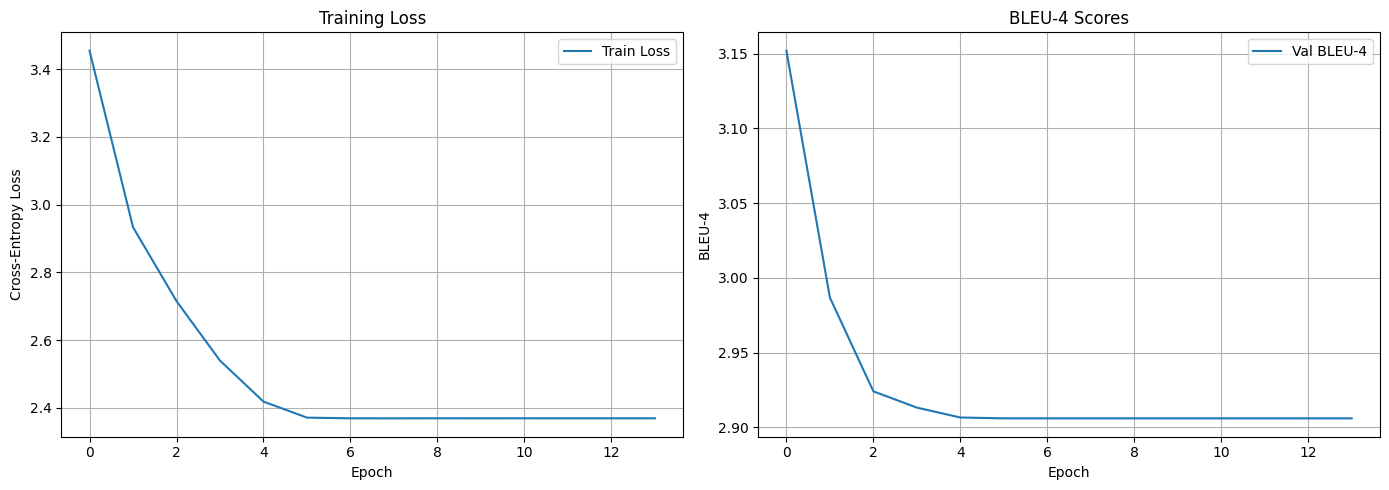

In [19]:
model.plot_history()

In [20]:
print("Evaluating on test set:")
model.evaluate_bleu(processor.test_data, max_samples=1000)

Evaluating on test set:


100%|██████████| 1000/1000 [08:57<00:00,  1.86it/s]


BLEU-1: 0.5117
BLEU-2: 0.2935
BLEU-3: 0.1811
BLEU-4: 0.1208


{'bleu-1': 0.5117142857142857,
 'bleu-2': 0.2934713794383543,
 'bleu-3': 0.18105836326962832,
 'bleu-4': 0.12082729285916584}

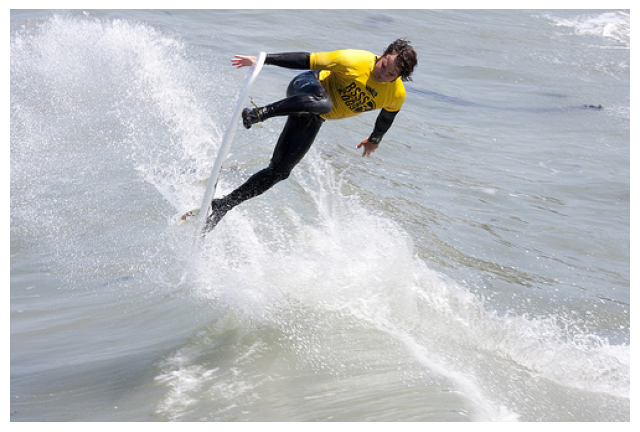

Ground-truth captions:
- A young male surfer wearing a yellow shirt rides a wave in the ocean on his whiteboard .
- A surfer in a yellow and black wetsuit is falling off a breaking wave .
- A young man in a yellow shirt flies off his surfboard into a wave .
- A surfer on his white surfboard catching a wave .
- A man in a wetsuit is surfing on the ocean .

Generated caption:
a man in a blue shirt is standing in front of a microphone .


Audio saved to caption_audio01.mp3


In [21]:
sample_pair = random.choice(processor.test_data)
sample_img = os.path.join(CONFIG['image_dir'], sample_pair[0])
model.demo(sample_img, filename='caption_audio01.mp3')

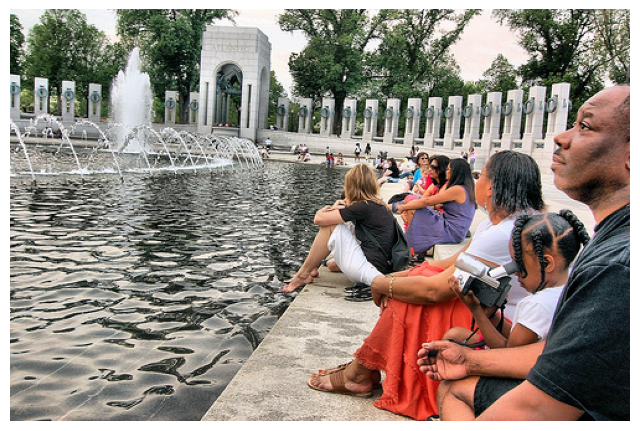

Ground-truth captions:
- People of all ages sit and look at the water and fountains in a popular spot , surrounded by white pillars .
- A large fountain with several people sitting along the right side .
- A group of people sitting beside a large beautiful fountain .
- A .group of diverse people around a memorial
- People hanging by a fountain on a warm day .

Generated caption:
a man in a blue shirt is standing in front of a microphone .


Audio saved to caption_audio02.mp3


In [22]:
sample_pair = random.choice(processor.test_data)
sample_img = os.path.join(CONFIG['image_dir'], sample_pair[0])
model.demo(sample_img, filename='caption_audio02.mp3')

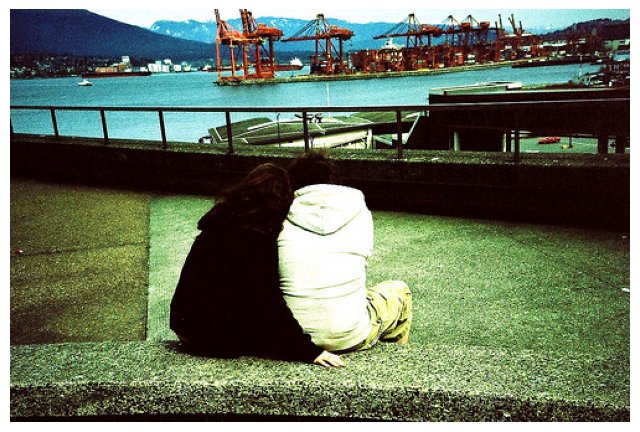

Ground-truth captions:
- A couple sits on a concrete pier watching oil rigs on the water with mountains in the distance .
- Two people are cuddling while overlooking a harbor with mountains in the distance .
- A couple sit in each others embrace as they gaze out at the river .
- Two people cuddle near a railing overlooking water and mountains .
- A boy and a girl sit while facing the water .

Generated caption:
a man in a blue shirt is standing in front of a microphone .


Audio saved to caption_audio03.mp3


In [23]:
sample_pair = random.choice(processor.test_data)
sample_img = os.path.join(CONFIG['image_dir'], sample_pair[0])
model.demo(sample_img, filename='caption_audio03.mp3')

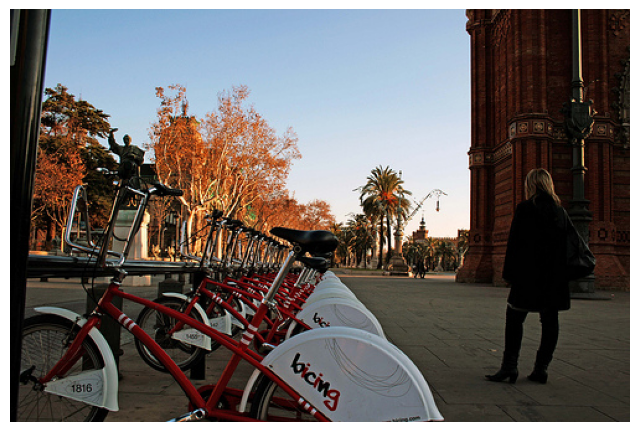

Ground-truth captions:
- A person is standing near a row of identical red and white bicycles .
- There is a row of red and white bikes all in a bike rack .
- A woman stands near a row of identical red bicycles .
- A woman is standing outside near many bicycles .
- A woman standing near a bike rack .

Generated caption:
a man in a blue shirt is standing in front of a microphone .


Audio saved to caption_audio04.mp3


In [24]:
sample_pair = random.choice(processor.test_data)
sample_img = os.path.join(CONFIG['image_dir'], sample_pair[0])
model.demo(sample_img, filename='caption_audio04.mp3')

In [25]:
# sample_pair = random.choice(processor.test_data)
# sample_img = os.path.join(CONFIG['image_dir'], sample_pair[0])
# model.demo(sample_img, filename='caption_audio05.mp3')